In [7]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
import matplotlib as mpl
format_k = lambda x, pos: f'{x/10**3:,.0f}K'
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')
import warnings
# 忽略 pandas 警告
warnings.filterwarnings('ignore')
from matplotlib import font_manager

font_dirs = ['/home/user/yan/Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
plt.rcParams['axes.labelsize'] = 16

plt.rcParams['font.size'] = 16
#设置x轴和y轴的 tick label 的大小
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16


In [101]:
import pandas as pd
from tqdm import tqdm
#分块阅读一个非常大的 csv 文件
# import vaex
# df=vaex.from_csv('/srv/abacus-3/Ethereum_token_txs_data/uniswapv2/uni-v2-pairs_with_tokens_decimal.csv',convert=True, chunk_size=5_000_000)
def read_large_csv(file_path, chunk_size=10000000):
    accumulated_data = pd.DataFrame()
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in tqdm(chunks):
        accumulated_data = pd.concat([accumulated_data, chunk])
    return accumulated_data

In [5]:
attestation_reward=read_large_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/eth2_reward_ether/daily_attestation_reward/total_daily_attestation_rewards_sum.csv')

0it [00:00, ?it/s]

30it [01:42,  3.40s/it]


In [6]:
attestation_reward.head(2)

,date,validator_index,total_reward
0,2022-09-15,0,2332229.0
1,2022-09-15,1,2300439.0


## daily number of attestors and validators

In [7]:
daily_attestors=attestation_reward.groupby('date')[['validator_index']].count().reset_index()

In [3]:
depositing=pd.read_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/eth2_reward_ether/beaconchain_deposit_until_block_20362089_included_add.csv')
depositing.sort_values(by='validator_index',inplace=True)
block_timestamp=pd.read_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/eth2_reward_ether/timestamp_20081108.csv')
depositing1=depositing.merge(block_timestamp,how='left',on='block_number')
depositing1=depositing1[depositing1['timestamp'].isnull()==False]
depositing1['date']=pd.to_datetime(depositing1['timestamp'],unit='s').dt.date
validator_daily_cumulative_number=depositing1.groupby('date')[['log_index']].count().cumsum()

In [24]:
validator_daily_cumulative_number['date'] = pd.to_datetime(validator_daily_cumulative_number['date'])
validator_daily_cumulative_number = validator_daily_cumulative_number[validator_daily_cumulative_number['date'] <= pd.Timestamp('2023-12-31')]
validator_daily_cumulative_number = validator_daily_cumulative_number[validator_daily_cumulative_number['date'] >= pd.Timestamp('2022-09-15')]
validator_daily_cumulative_number.rename(columns={'log_index':'validator_cum_number'},inplace=True)

In [29]:
validator_daily_cumulative_number.shape

(473, 3)

In [28]:
daily_attestors.shape


(473, 2)

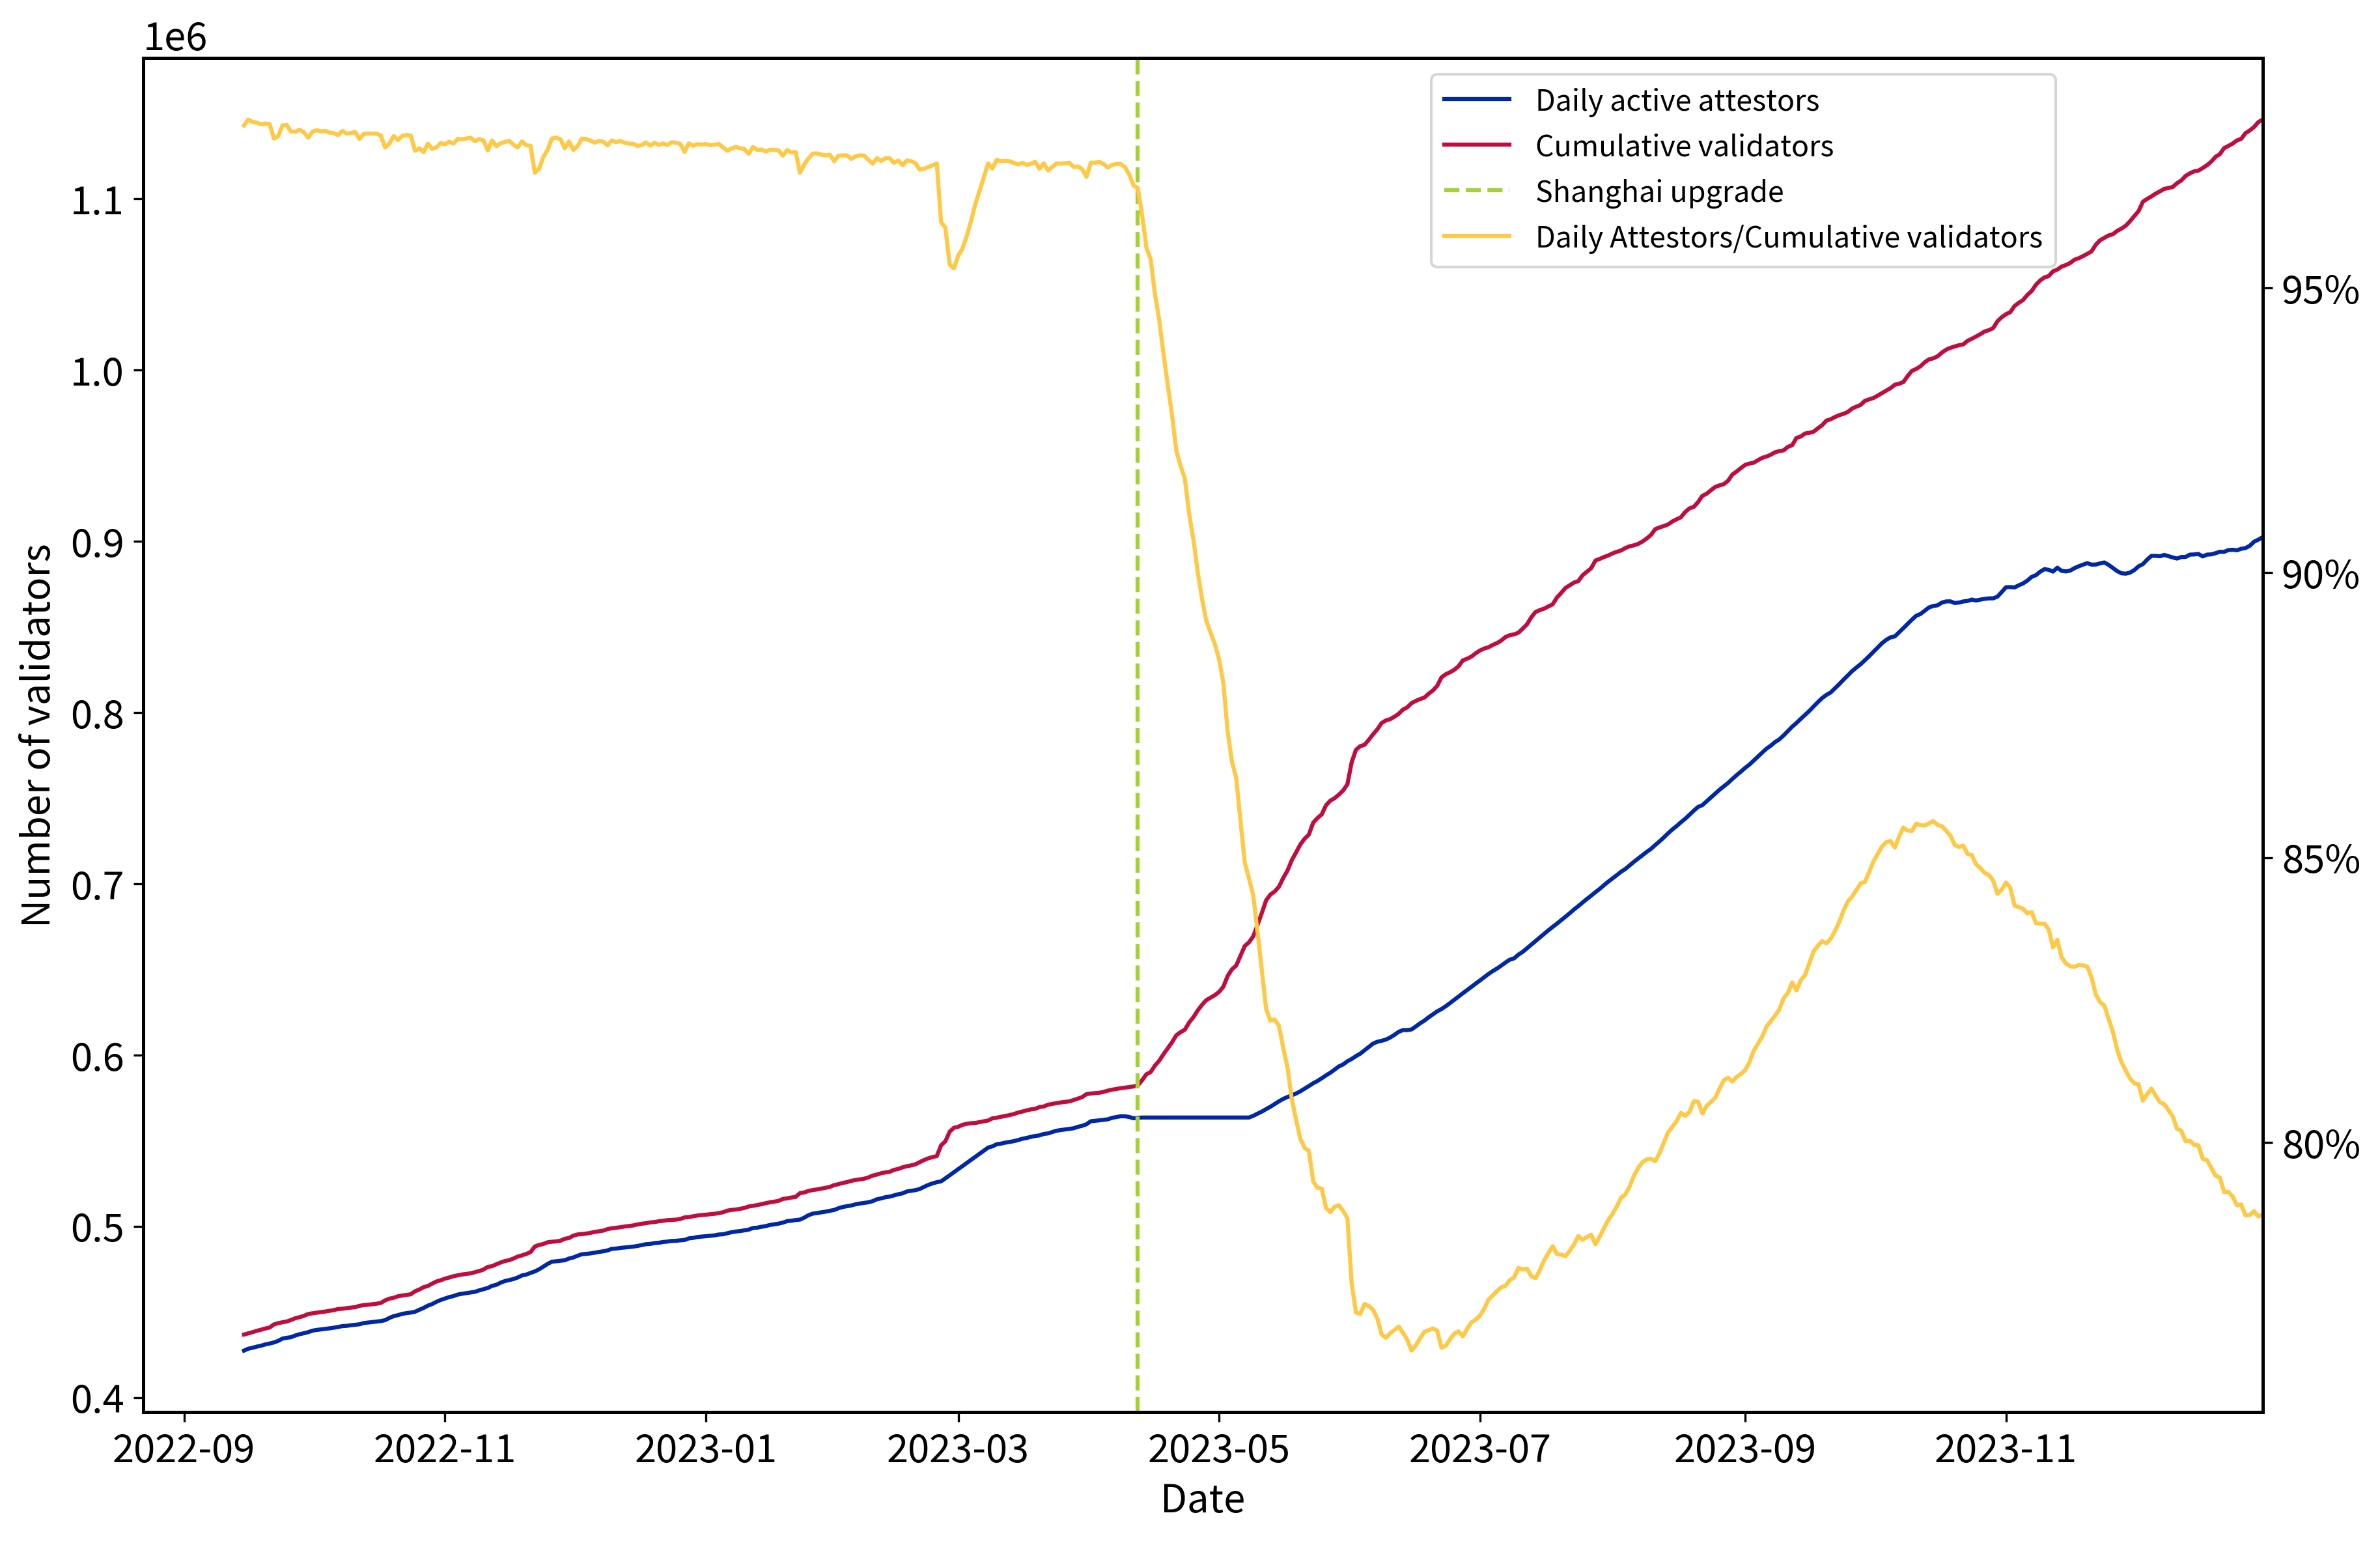

In [66]:
daily_attestors.rename(columns={'validator_index':'attestors'},inplace=True)
daily_attestors=daily_attestors[daily_attestors['date']<='2023-12-31']
daily_attestors['date']=pd.to_datetime(daily_attestors['date'])
fig,ax=plt.subplots(figsize=(14,9))
ax.plot(daily_attestors['date'],daily_attestors['attestors'],label='Daily active attestors')
ax.plot(validator_daily_cumulative_number['date'],validator_daily_cumulative_number['validator_cum_number'],label='Cumulative validators')
ax.set_xlabel('Date')
ax.set_ylabel('Number of validators')
#x的截止日期为2023年12 月
ax.set_xlim(None,pd.Timestamp('2023-12-31'))

#画一条竖线,表示上海升级，2023 年 4 月 12 日
next_color =ax._get_lines.get_next_color()
ax.axvline(pd.Timestamp('2023-04-12'),linestyle='--',label='Shanghai upgrade',color=next_color)

next_color =ax._get_lines.get_next_color()
ax2=ax.twinx()
#画出每天的验证者数量/每天的验证者数量
# 重新定义颜色循环
# ax2.set_prop_cycle(mpl.cycler('color'))
ax2.plot(daily_attestors['date'],daily_attestors['attestors'].values/validator_daily_cumulative_number['validator_cum_number'].values,label='Daily Attestors/Cumulative validators',color=next_color)
#将 ax 和 ax2 的图例合并
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.6, 1), loc='upper left')
#ax2 的 Y轴用百分比显示
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.savefig('./plots/validator_daily_cumulative_number.jpg',bbox_inches='tight',dpi=300,facecolor='white')

In [67]:
(daily_attestors['attestors'].values/validator_daily_cumulative_number['validator_cum_number'].values).min()

0.7634197669582276

## PoW reward gini

In [106]:
pow_reward=read_large_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/pow_reward.csv')

0it [00:00, ?it/s]

2it [00:11,  5.92s/it]


In [107]:
pow_reward.head(2)

,block_number,address,reward,reward_type
0,0,0x0000000000000000000000000000000000000000,5.0,miner_reward
1,1,0x05a56e2d52c817161883f50c441c3228cfe54d9f,5.0,miner_reward


In [108]:
#索引不连续，重新设置索引
pow_reward.reset_index(drop=True,inplace=True)

In [109]:
#添加 block_timestamp
pow_reward=pow_reward.merge(block_timestamp,how='left',on='block_number')

In [110]:
pow_reward['date']=pd.to_datetime(pow_reward['timestamp'],unit='s').dt.date

In [111]:
pow_reward.head(2)

,block_number,address,reward,reward_type,timestamp,date
0,0,0x0000000000000000000000000000000000000000,5.0,miner_reward,1438226773,2015-07-30
1,1,0x05a56e2d52c817161883f50c441c3228cfe54d9f,5.0,miner_reward,1438269988,2015-07-30


In [122]:
daily_reward=pow_reward.groupby(['date','address'])[['reward']].sum().reset_index()

In [123]:
daily_reward['address']=daily_reward['address'].str.lower()

## are some miners in the validators

In [114]:
## 
depositing1.head(2)

,beacon_deposit_contract,block_hash,block_number,event,log_index,tx_hash,tx_index,amount,validator_index,signature,pubkey,withdrawal_credentials,order_in_tx,depositor_address,to,timestamp,date
0,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x1ecb9dd23676c9201af1e8026e7d83a1f979b8abd381...,11185311,DepositEvent,131,0x7085c586686d666e8bb6e9477a0f0b09565b2060a11f...,104,1000000000,0,0xa29d01cc8c6296a8150e515b5995390ef841dc18948a...,0x933ad9491b62059dd065b560d256d8957a8c402cc6e8...,0x00f50428677c60f997aadeab24aabf7fceaef491c96a...,1,0x798cf8fc6f212da30b10cac6e05b4bf275c34bff,0x00000000219ab540356cbb839cbe05303d7705fa,1.604422e+09,2020-11-03
1,0x00000000219ab540356cBB839Cbe05303d7705Fa,0xa51cbe797cac4ef0297862576e64444a90d3bec33294...,11191448,DepositEvent,126,0xa90ed27521c07e66d52db6ee47d729d1182299253037...,74,1000000000,1,0x985f365b3459176da437560337cc074d153663f65e3c...,0xa1d1ad0714035353258038e964ae9675dc0252ee22ce...,0x0092c20062cee70389f1cb4fa566a2be5e2319ff4396...,1,0xc34eb7e3f34e54646d7cd140bb7c20a466b3e852,0x00000000219ab540356cbb839cbe05303d7705fa,1.604503e+09,2020-11-04


In [115]:
depositing1.tail()

,beacon_deposit_contract,block_hash,block_number,event,log_index,tx_hash,tx_index,amount,validator_index,signature,pubkey,withdrawal_credentials,order_in_tx,depositor_address,to,timestamp,date
1533477,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x5f89afe48d1cac5c11ac28afcf7dac4af7ca74b312a8...,20080814,DepositEvent,329,0x3cf623cc62785426012317961d91b56ceffbce14d634...,5,31000000000,1533477,0x82583a70bf360560700ecac2aa363cc945217f98c361...,0xa70d0047f1dcaca68b378965dc8443bb3bf74322e5b8...,0x01000000000000000000000063fbbab025c8e185d7e2...,96,0x25e821b7197b146f7713c3b89b6a4d83516b912d,0x00000000219ab540356cbb839cbe05303d7705fa,1.718256e+09,2024-06-13
1533478,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x5f89afe48d1cac5c11ac28afcf7dac4af7ca74b312a8...,20080814,DepositEvent,331,0x3cf623cc62785426012317961d91b56ceffbce14d634...,5,31000000000,1533478,0xa1ef85b172010bbd4c4ba4644048fbe37178b5c97d7e...,0xae609caf77c5336a72ddf5825e31e2905d264d75fcee...,0x01000000000000000000000063fbbab025c8e185d7e2...,97,0x25e821b7197b146f7713c3b89b6a4d83516b912d,0x00000000219ab540356cbb839cbe05303d7705fa,1.718256e+09,2024-06-13
1533479,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x5f89afe48d1cac5c11ac28afcf7dac4af7ca74b312a8...,20080814,DepositEvent,333,0x3cf623cc62785426012317961d91b56ceffbce14d634...,5,31000000000,1533479,0xb5edc4a3e12ce7a4a4c418f61ebcb3cc7d02f5253121...,0xb97d8d5cca2329d766920e0048e24529b81f945999b3...,0x01000000000000000000000063fbbab025c8e185d7e2...,98,0x25e821b7197b146f7713c3b89b6a4d83516b912d,0x00000000219ab540356cbb839cbe05303d7705fa,1.718256e+09,2024-06-13
1533480,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x5f89afe48d1cac5c11ac28afcf7dac4af7ca74b312a8...,20080814,DepositEvent,335,0x3cf623cc62785426012317961d91b56ceffbce14d634...,5,31000000000,1533480,0x8ff961cecd66be6738a4b316760c234daafdb3895c3d...,0x97c4346d3786f057314eee730c95ee3bdf774b4d256a...,0x01000000000000000000000063fbbab025c8e185d7e2...,99,0x25e821b7197b146f7713c3b89b6a4d83516b912d,0x00000000219ab540356cbb839cbe05303d7705fa,1.718256e+09,2024-06-13
1533481,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x5f89afe48d1cac5c11ac28afcf7dac4af7ca74b312a8...,20080814,DepositEvent,337,0x3cf623cc62785426012317961d91b56ceffbce14d634...,5,31000000000,1533481,0xb672ebede7f1c0e6da4350f2f9b6358c4ac5f46ba30c...,0x97ec7d557db2576841bef088b0dca1c37e8937d84d2a...,0x01000000000000000000000063fbbab025c8e185d7e2...,100,0x25e821b7197b146f7713c3b89b6a4d83516b912d,0x00000000219ab540356cbb839cbe05303d7705fa,1.718256e+09,2024-06-13


In [116]:
depositing1['depositor_address'].nunique()

193838

In [117]:
miners=pd.read_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/pow_reward.csv')

In [118]:
miners_reward=miners[miners['reward_type']=='miner_reward']
miners_reward.shape

(15537393, 4)

In [119]:
miner_address=pd.read_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/mining_135.csv')
miner_address.rename(columns={'Address':'address'},inplace=True)
miner_address['address']=miner_address['address'].str.lower()

In [120]:
miners_reward_label=miners_reward.merge(miner_address,how='left',on='address')

In [36]:
#看有多少 miner address 在 validator的 from address 中
miners_reward_label['address']=miners_reward_label['address'].str.lower()
miners_reward_label['address'].isin(depositing1['depositor_address']).sum()

1688

In [99]:
v1=miners_reward_label['address'].unique()
v2=depositing1['depositor_address'].unique()
#区交集
v3=set(v1).intersection(set(v2))
ff=miners_reward_label[miners_reward_label['address'].isin(v3)]
ff
# ff[ff['Name Tag'].notnull()]

,block_number,address,reward,reward_type,Name Tag,Balance,Txn Count
19597,19597,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
20963,20963,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
20964,20964,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
21716,21716,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
21781,21781,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15604182,15482611,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15619932,15498024,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15629123,15507005,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15629546,15507425,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN


In [37]:
miners_become_validators=miners_reward_label[miners_reward_label['address'].isin(depositing1['depositor_address'])]
miners_become_validators

,block_number,address,reward,reward_type,Name Tag,Balance,Txn Count
19597,19597,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
20963,20963,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
20964,20964,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
21716,21716,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
21781,21781,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15604182,15482611,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15619932,15498024,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15629123,15507005,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15629546,15507425,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN


In [40]:
miners_become_validators

,block_number,address,reward,reward_type,Name Tag,Balance,Txn Count
19597,19597,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
20963,20963,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
20964,20964,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
21716,21716,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
21781,21781,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15604182,15482611,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15619932,15498024,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15629123,15507005,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN
15629546,15507425,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward,NaN,NaN,NaN


In [39]:
miners_become_validators[miners_become_validators['Name Tag'].notnull()]

,block_number,address,reward,reward_type,Name Tag,Balance,Txn Count


In [26]:
miners_become_validators

,block_number,address,reward,reward_type
19597,19597,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward
20963,20963,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward
20964,20964,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward
21716,21716,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward
21781,21781,0x55baf64fc9eaccffd7cc643bb61142e1c6ac093e,5.0,miner_reward
...,...,...,...,...
15482611,15482611,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward
15498024,15498024,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward
15507005,15507005,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward
15507425,15507425,0x3441a43051ed707674dc1d42db9091e38c260ab3,2.0,miner_reward


In [27]:
depositing1['depositor_address']=depositing1['depositor_address'].str.lower()
depositors_are_miners=depositing1[depositing1['depositor_address'].isin(miners_reward['address'])]
depositors_are_miners['depositor_address'].nunique()

12

In [31]:
depositors_are_miners

,beacon_deposit_contract,block_hash,block_number,event,log_index,tx_hash,tx_index,amount,validator_index,signature,pubkey,withdrawal_credentials,order_in_tx,depositor_address,to,timestamp,date
486,0x00000000219ab540356cBB839Cbe05303d7705Fa,0xbaa9080a6dc3f6c1050ef49f8a0eb9a2678bf5b64095...,11195530,DepositEvent,219,0x20f07b1921dab542d1af934b2b3dda5d177f969b26b1...,130,32000000000,486,0xa7703071cafb96a7e4de9d9208c49abb6abdda8342a9...,0xb82611120fde77a90085375043be1a6a2d0877d57054...,0x00b7f85dd9cf4042b74784434b6e34d33de660865afb...,1,0xb1ca2dc4bc26ee6224811f9a801e13e5479951de,0x00000000219ab540356cbb839cbe05303d7705fa,1.604557e+09,2020-11-05
1908,0x00000000219ab540356cBB839Cbe05303d7705Fa,0xca5fd790e152f9e0639c3e5455000216026ade37f481...,11247417,DepositEvent,106,0x4ac11f8c84c2af62cf60f1e247b2af54bedf52bbaffd...,36,32000000000,1908,0xb9c5095d66cbae7ce76e1e3762542a639f113a684d9f...,0xb40704cbc4de8d3884254219a476743fe6382771ce80...,0x00051653c7cbef4ca1fefe08fdc16b252d0da0ceef25...,1,0x84256d81c1a191e6952c781f6a204626c6912b83,0x00000000219ab540356cbb839cbe05303d7705fa,1.605245e+09,2020-11-13
7466,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x69a319050cceb754368798ddf8b7d156f8fe7ebea68d...,11306243,DepositEvent,182,0xca5c6366fa5fef0fb6a89d1b952e19d79fb8f2566c13...,62,32000000000,7466,0x85dee6175464292dc47f447396d070af3b4fb2aa3839...,0xa307a8d41699ba1a540cb36446d076086c33ad414ad6...,0x004b2083ff259e68c3b78a050d689eb8bbf871af389f...,1,0x9f2070efa98cc424012fe182c2c6cc0aff8d12db,0x00000000219ab540356cbb839cbe05303d7705fa,1.606024e+09,2020-11-22
7470,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x86f1bcec467d15651d26d28397b36d2f80d2d8201290...,11306303,DepositEvent,246,0x656219d6bfd41629203fbfa19af4a56994b705fe6b37...,146,32000000000,7470,0x8127581f09642b336afcfa27d58879c69da798ff6b09...,0xacce86745cffc897533e702e1882b700bf5a9e1972c6...,0x008242b11ae5c4a2d382fae4aab0762e4e0ed4dba774...,1,0x9f2070efa98cc424012fe182c2c6cc0aff8d12db,0x00000000219ab540356cbb839cbe05303d7705fa,1.606025e+09,2020-11-22
7471,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x86f1bcec467d15651d26d28397b36d2f80d2d8201290...,11306303,DepositEvent,247,0x39cb52c0a50aaa1e508ef7c268eb45fb6160f1110cf5...,147,32000000000,7471,0xb1053a5473fb2163aea1fe2bbf9f73cfe4fc3c34df88...,0xa1e5a3b95787674ae27166b43b92572315174e9e3f7d...,0x006c0dd61a91481160f945560d2453c97cc3f6069040...,1,0x9f2070efa98cc424012fe182c2c6cc0aff8d12db,0x00000000219ab540356cbb839cbe05303d7705fa,1.606025e+09,2020-11-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064168,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x519cdc75b5896de8f6b3b4459e5364aaf0ed60aae5a8...,18593863,DepositEvent,601,0x94cf7c2aafb8258b3a4650af169f36565481fc1ce03a...,336,32000000000,1064168,0x8f028e5641094d3ef3b615ddba66564069047bdc84ef...,0x9491fed08bb2c9942fea9d97ce3b7f2d9de6303f7b65...,0x01000000000000000000000019a7906f489d20bdbc49...,1,0xffcd9cae6d9f54fd8ae05296f839892677ff6eaa,0x00000000219ab540356cbb839cbe05303d7705fa,1.700251e+09,2023-11-17
1064169,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x519cdc75b5896de8f6b3b4459e5364aaf0ed60aae5a8...,18593863,DepositEvent,602,0xe50479edb096cb0e8c22558da54d21cb8b13e6f1a3a4...,337,32000000000,1064169,0x98a6e6a8f49f9d3d1247b9399e0cbe712ba21d4fa673...,0xaf1aeef002fd0bc6816f7a4bd32aee70ad72286d3226...,0x01000000000000000000000019a7906f489d20bdbc49...,1,0xffcd9cae6d9f54fd8ae05296f839892677ff6eaa,0x00000000219ab540356cbb839cbe05303d7705fa,1.700251e+09,2023-11-17
1064170,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x519cdc75b5896de8f6b3b4459e5364aaf0ed60aae5a8...,18593863,DepositEvent,603,0xeb134d321b7196764dd0d84ad4beba95cafecec6c63b...,338,32000000000,1064170,0x810196b3e761f0be5e549a024c9db2f6ac27e166282f...,0xa4cee9dcc4477a78c2315c6b8ad4ea302b5527031c04...,0x01000000000000000000000019a7906f489d20bdbc49...,1,0xffcd9cae6d9f54fd8ae05296f839892677ff6eaa,0x00000000219ab540356cbb839cbe05303d7705fa,1.700251e+09,2023-11-17
1064171,0x00000000219ab540356cBB839Cbe05303d7705Fa,0x519cdc75b589

In [73]:
#计算每天累计的不重复的depositor_address有多少个
dates=depositors_are_miners['date'].unique()
dates=np.sort(dates)
cumulative_miners=[]
for date in dates:
    cumulative_miners.append(depositors_are_miners[depositors_are_miners['date']<=date]['depositor_address'].nunique())
cumulative_miners=pd.DataFrame({'date':dates,'cumulative_miners':cumulative_miners})

In [74]:
cumulative_miners

,date,cumulative_miners
0,2020-11-05,1
1,2020-11-13,2
2,2020-11-22,3
3,2020-11-24,4
4,2020-11-28,5
5,2020-11-30,7
6,2021-02-15,7
7,2021-05-26,8
8,2022-04-27,9
9,2022-10-24,10


In [65]:
#根据depositors_are_miners的depositor_address列统计每天累计的 unique depositor_address数量，生成新的一列，需要和之前日期的depositor_address比较，如果之前出现了，那么当天的数量就不加1
depositors_are_miners['date']=pd.to_datetime(depositors_are_miners['date'])
depositors_are_miners['depositor_address']=depositors_are_miners['depositor_address'].str.lower()
depositors_are_miners['unique_cumulative_miner_depositors']=depositors_are_miners.groupby('date')['depositor_address'].cumcount()+1


In [43]:
miner_depositor_unique_count_daily=depositors_are_miners.groupby('date')[['depositor_address']].nunique().reset_index()
miner_depositor_count_daily=depositors_are_miners.groupby('date')[['depositor_address']].count().reset_index()

In [ ]:
miner_depositor_daily=pd.merge(miner_depositor_count_daily,miner_depositor_unique_count_daily,on='date')
miner_depositor_daily.rename(columns={'depositor_address_x':'miner_depositing_count','depositor_address_y':'unique_miner_depositing_count'},inplace=True)
miner_depositor_daily.sort_values(by='date',inplace=True)

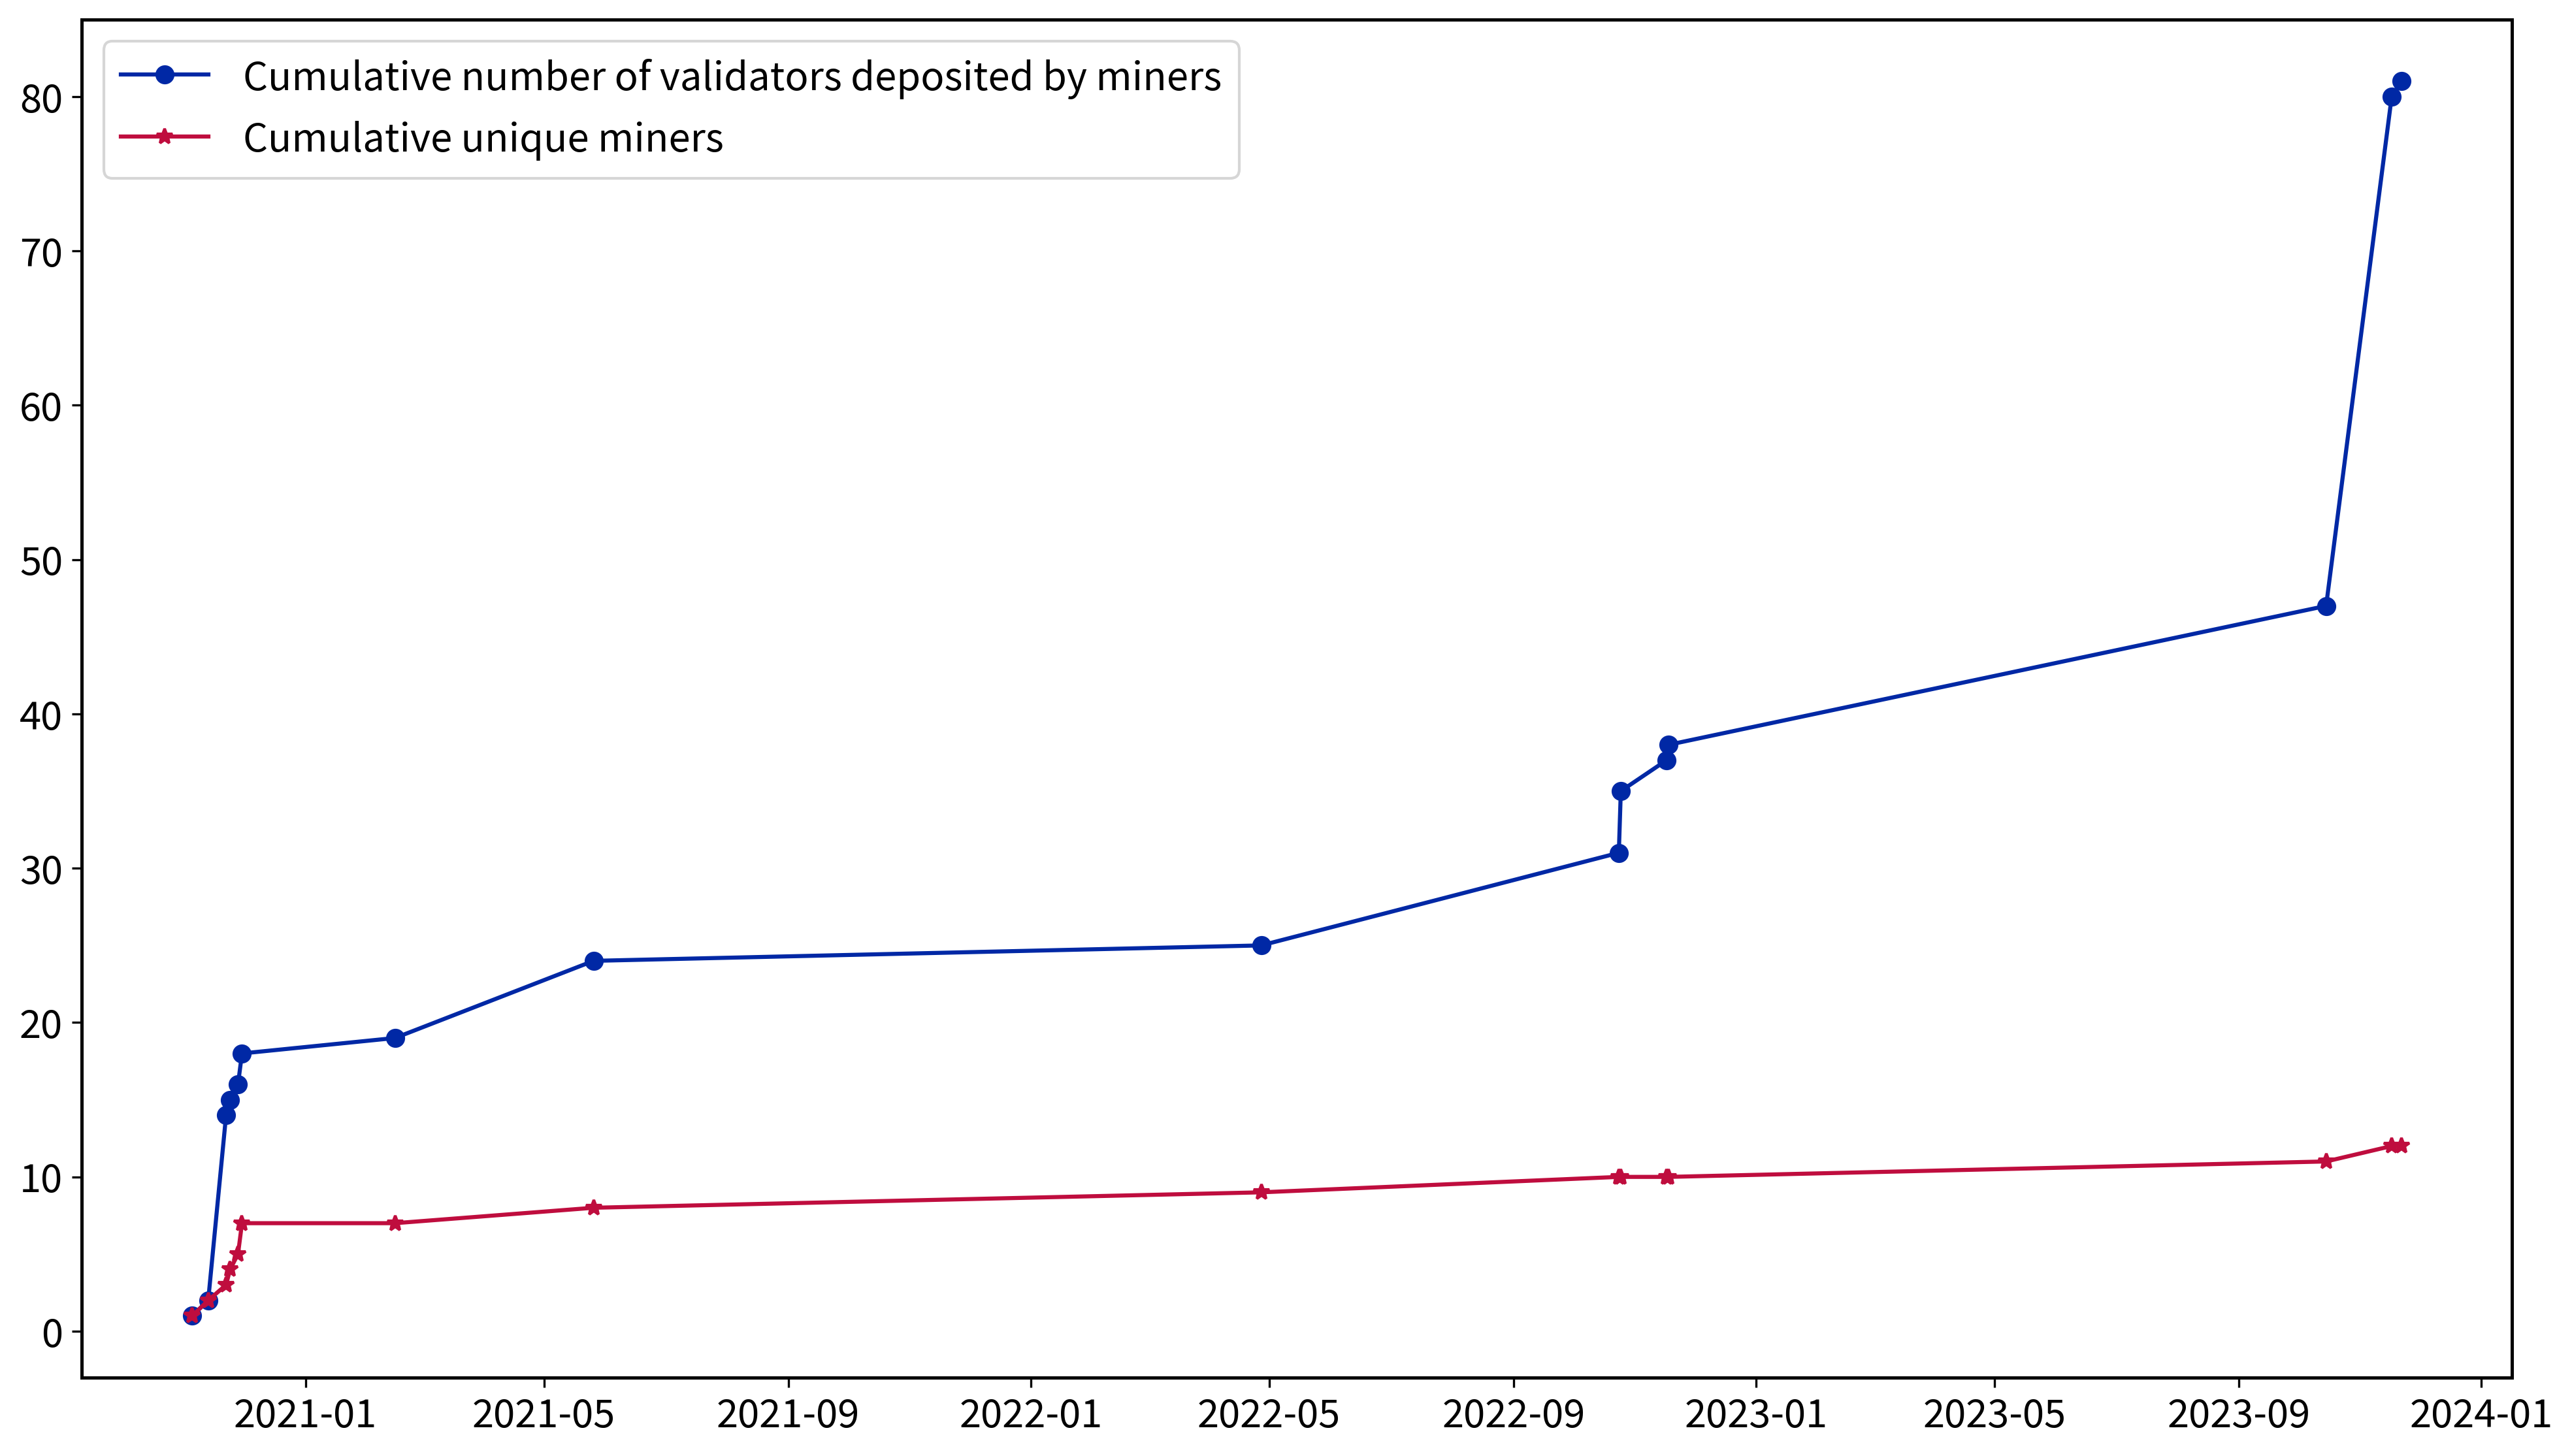

In [93]:
#画图展示miner_depositing_count和unique_miner_depositing_count,画堆叠的bar图
fig,ax=plt.subplots(figsize=(16,9))
ax.plot(miner_depositor_daily['date'],miner_depositor_daily['miner_depositing_count'].cumsum(),label='Cumulative number of validators deposited by miners',marker='o')
ax.plot(cumulative_miners['date'],cumulative_miners['cumulative_miners'],label='Cumulative unique miners',marker='*')
ax.legend()
plt.savefig('./plots/miners_and_validators.jpg',bbox_inches='tight',dpi=300,facecolor='white')

In [79]:
ax.set_xlabel('Date')
ax.set_ylabel('Number of miner depositors')
ax.legend()

In [80]:
miners_reward['address'].nunique()

5624

## 把 miner address 和 address label 关联起来

In [103]:
miner_address=pd.read_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/mining_135.csv')
miner_address.rename(columns={'Address':'address'},inplace=True)
miner_address['address']=miner_address['address'].str.lower()

In [104]:
daily_reward

NameError: name 'daily_reward' is not defined

In [82]:
daily_reward1=daily_reward.merge(miner_address[['address','Name Tag']],how='left',on='address')

NameError: name 'daily_reward' is not defined

In [ ]:
daily_reward1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164103 entries, 0 to 164102
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      164103 non-null  object 
 1   address   164103 non-null  object 
 2   reward    164103 non-null  float64
 3   Name Tag  66314 non-null   object 
dtypes: float64(1), object(3)
memory usage: 5.0+ MB


In [ ]:
daily_reward1.to_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/daily_address_reward_pow.csv',index=False)

In [ ]:
daily_reward1.head(2)

,date,address,reward,Name Tag
0,2015-07-30,0x0000000000000000000000000000000000000000,80.0,NaN
1,2015-07-30,0x00ea19cfd3764eff21016a4e038850ac06f98d37,5.0,NaN


## 计算daily gini

In [ ]:
#见/home/user/yan/github/ETH2.0-reward/code/pow_pos/calculate_pow_gini.py结果

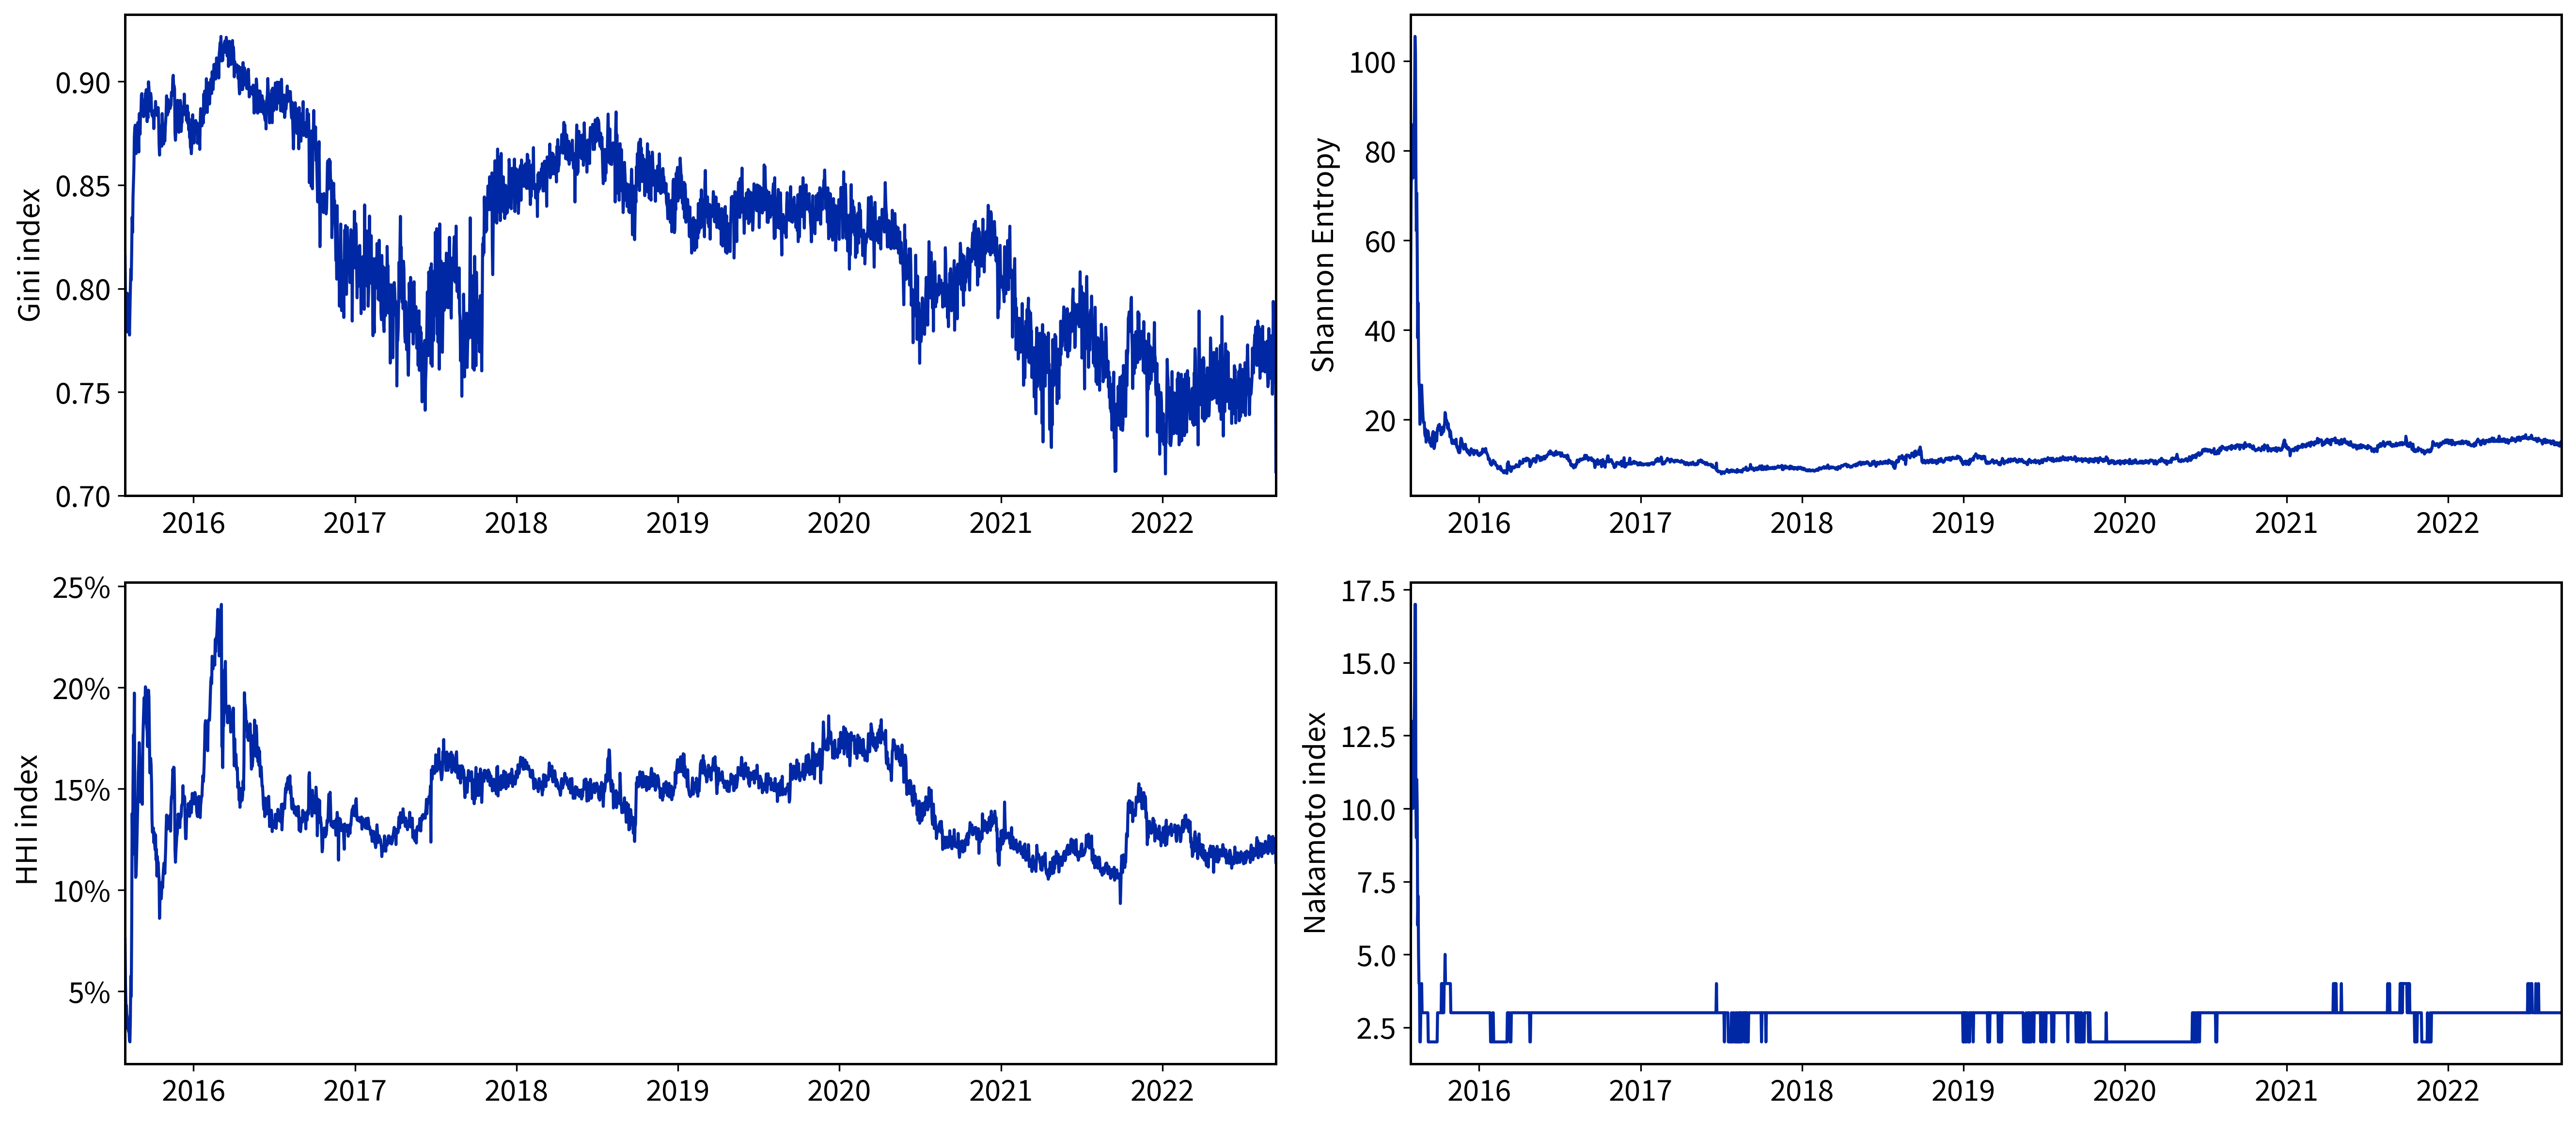

In [161]:
##画图表示集中 index 变化
from glob import glob
start_date='2015-07-30'
files=glob('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/decentralization_index/*.csv')
# validator_counts =pd.read_csv('/home/user/yan/github/ETH2.0-reward/data/daily_validator_number_new.csv')
# 2*2 subplots
fig,axes=plt.subplots(2,2,figsize=(18,8),dpi=300)
for file in files:
    index=pd.read_csv(file)
    index['date']=pd.to_datetime(index['date'])
    index_name=file.split('/')[-1].split('.')[0].split('_')[0]
    index_name=index_name[0].upper()+index_name[1:]
    reward_type=file.split('/')[-1].split('.')[0].split('_')[1]
    # reward_type=['Total','Proposer','Attestor','Sync committee member']
    if index_name=='Gini':
        axes[0,0].plot(index['date'],index[reward_type],label=reward_type)
        #set the y-axis label
        axes[0,0].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[0,0].legend(fontsize=16,ncol=2)
        axes[0,0].autoscale(enable=True, axis='x', tight=True)
        axes[0,0].set_xlim(left=pd.to_datetime(start_date))
        # axes[0,0].set_yscale('log') 
    if index_name=='Index':
        axes[0,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[0,1].set_ylabel(f'Shannon Entropy',fontsize=16)
        #use percentage for y-axis
        # axes[0,1].legend(fontsize=16,ncol=2)
        axes[0,1].autoscale(enable=True, axis='x', tight=True)
        axes[0,1].set_xlim(left=pd.to_datetime(start_date))
    
    if index_name=='HHI':
        # reviese_HHI=index[reward_type]* validator_counts['validator_index'][1:].values
        axes[1,0].plot(index['date'],index[reward_type],label=reward_type)
        # axes[1,0].plot(index['date'],reviese_HHI,label=reward_type)
        axes[1,0].set_ylabel(f' HHI index',fontsize=16)
        #use percentage for y-axis
        axes[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        # axes[1,0].legend(fontsize=16,ncol=2)
        axes[1,0].autoscale(enable=True, axis='x', tight=True)
        axes[1,0].set_xlim(left=pd.to_datetime(start_date))
        # axes[1,0].set_yscale('log')
        
    if index_name=='Nakamoto':
        axes[1,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[1,1].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[1,1].legend(fontsize=16,ncol=2)
        axes[1,1].autoscale(enable=True, axis='x', tight=True)
        axes[1,1].set_xlim(left=pd.to_datetime(start_date))
plt.tight_layout()
#rename the legend
handles, labels = axes[0,0].get_legend_handles_labels()
labels[0]='Total'
# labels[1]='Proposer'
# labels[2]='Attestor'
# labels[3]='Sync committee member'
#set the legend location
# plt.legend(handles,labels,fontsize=16,ncol=4,bbox_to_anchor=(0.5,2.35),frameon=True)
# plt.savefig('../figure/4_index_timeseries.pdf',bbox_inches='tight',dpi=300,facecolor='white')
# plt.savefig('./plots/4_index_timeseries.jpg',bbox_inches='tight',dpi=300,facecolor='white')

## 计算累计财富的比例 donut chart

In [1]:
import pandas as pd
daily_reward1=pd.read_csv('/local/scratch/exported/Ethereum_token_txs_data_TY_23/rewards/mining_staking/mining/daily_address_reward_pow.csv')

In [2]:
daily_reward1.head(2)
#将 Name Tag 为空的行填充为 'Unknown'
daily_reward1['Name Tag'].fillna('Unknown',inplace=True)

In [3]:
mining_pool_reward=daily_reward1.groupby('Name Tag')[['reward']].sum().reset_index()

In [4]:
mining_pool_reward.sort_values(by='reward',ascending=False,inplace=True)

In [5]:
mining_pool_reward

,Name Tag,reward
114,Unknown,9720706.250
33,Ethermine,9332078.875
109,Spark Pool,4801537.000
25,DwarfPool,4714440.375
96,Nanopool,4641254.500
...,...,...
10,Baypool,147.000
82,Miner: 0xd7a...dBA,144.750
20,CoolPool.Top: SOLO,136.250
101,PoolHub,78.375


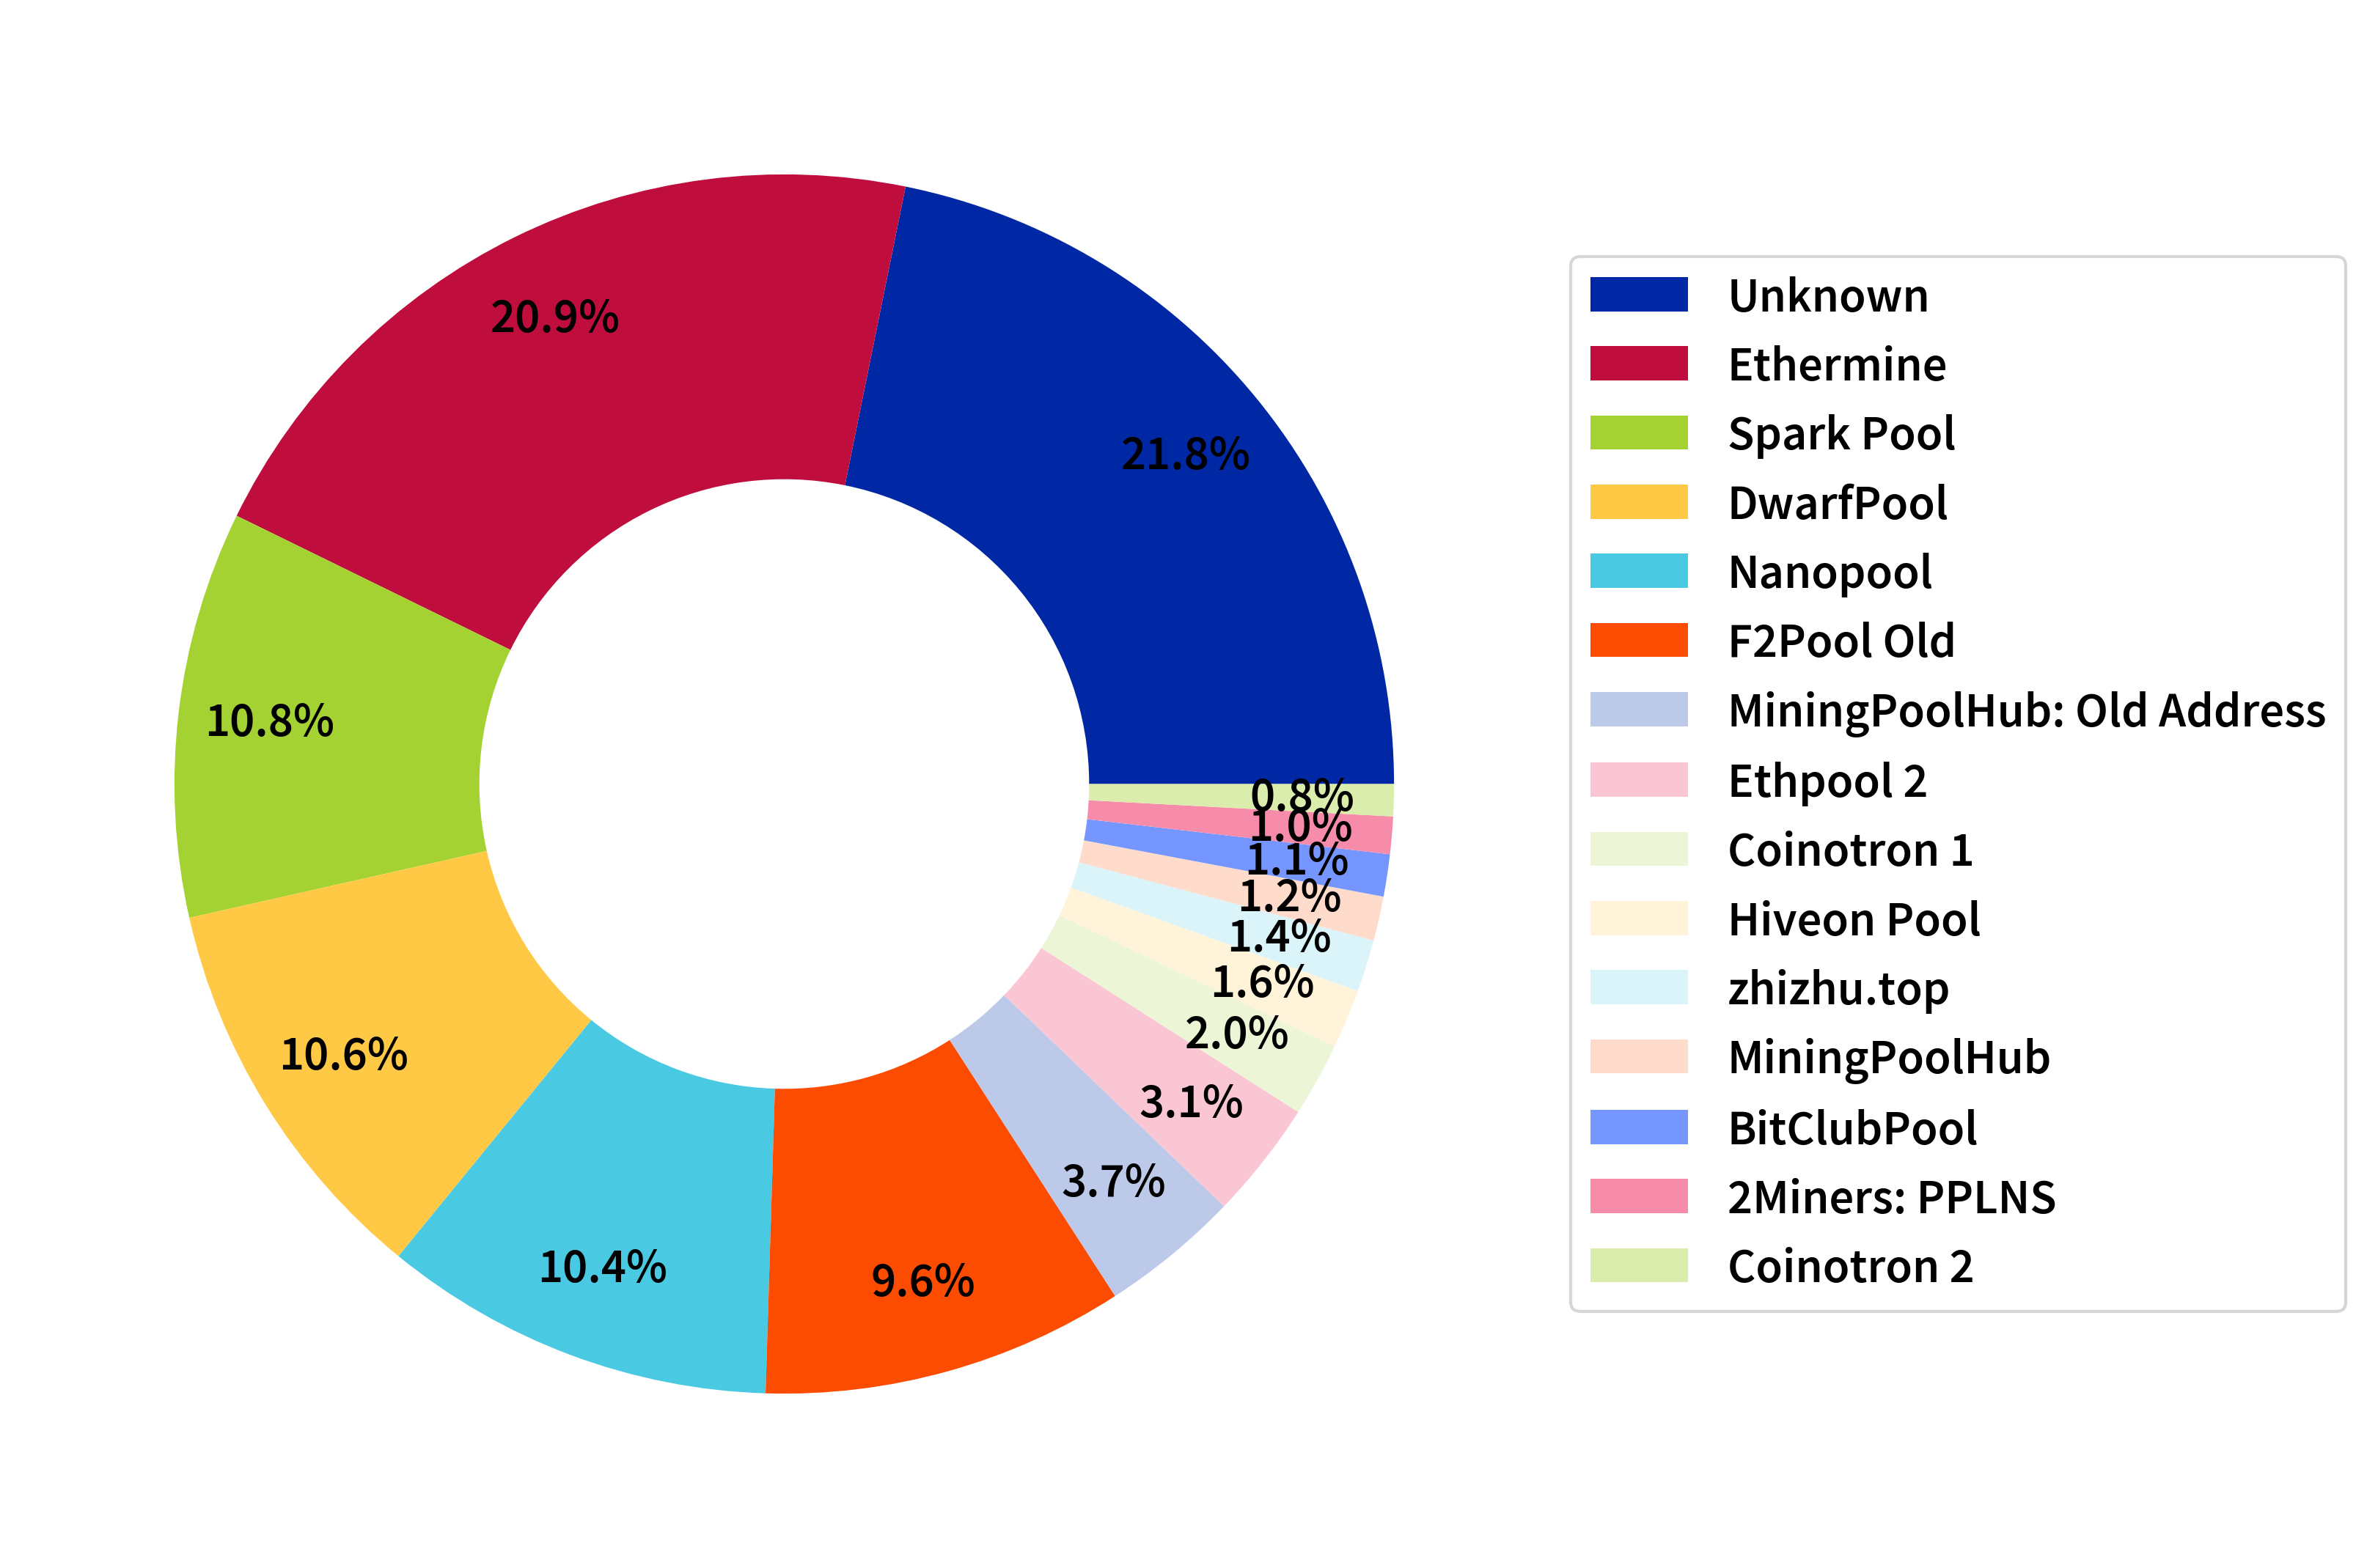

In [8]:
#画出各个实体的质押量,画一个圆环图
fig,ax=plt.subplots(figsize=(16,9))
# entity_amount=mining_pool_reward.groupby('Name Tag')['reward'].sum().sort_values(ascending=False)
#只画出前15个实体,其他的合并为其他
mining_pool_reward1=mining_pool_reward[:15]
# entity_amount['other']=entity_amount[15:].sum()
#画一个donut chart
ax.pie(mining_pool_reward1['reward'],autopct='%1.1f%%',wedgeprops=dict(width=0.5),pctdistance=0.85)
#把 name 放在右边
ax.legend(mining_pool_reward1['Name Tag'],loc='center left',bbox_to_anchor=(1,0,0.5,1))
#保留图例，去掉图上的 name 标签
# plt.savefig('/home/user/yan/github/ETH2.0-reward/code/pow_pos/plots/eth2_staking_ratiodonut.jpg',bbox_inches='tight',dpi=300,facecolor='white')


In [9]:
#用动图展示各个实体从 2015 年 7 月 31 日开始每个月质押的比例变化
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots(figsize=(16,9))
daily_reward1['date']=pd.to_datetime(daily_reward1['date'])
daily_reward1.sort_values(by='date',inplace=True)
daily_reward1['month']=daily_reward1['date'].dt.to_period('M')
daily_reward1['Name Tag'].fillna('Unknown',inplace=True)
# daily_reward1=daily_reward1[daily_reward1['Name Tag']!='Unknown']
#只画出前15个实体,其他的合并为其他
mining_pool_reward1=daily_reward1.groupby(['month','Name Tag'])[['reward']].sum().reset_index()
mining_pool_reward1.sort_values(by='month',inplace=True)
mining_pool_reward1['reward']=mining_pool_reward1['reward']/mining_pool_reward1['reward'].sum()
mining_pool_reward1=mining_pool_reward1[mining_pool_reward1['Name Tag'].isin(mining_pool_reward['Name Tag'][:15])]


In [10]:
mining_pool_reward1['reward']=mining_pool_reward1['reward'].astype(float)
mining_pool_reward1.sort_values(by=['month','reward'],ascending=[True,False],inplace=True)

In [11]:
mining_pool_reward1

,month,Name Tag,reward
0,2015-07,Unknown,0.001490
8,2015-08,Unknown,0.011582
6,2015-08,Nanopool,0.001576
2,2015-08,Coinotron 1,0.000011
18,2015-09,Nanopool,0.005312
...,...,...,...
2703,2022-09,Hiveon Pool,0.000371
2689,2022-09,2Miners: PPLNS,0.000267
2722,2022-09,MiningPoolHub,0.000159
2723,2022-09,Nanopool,0.000102


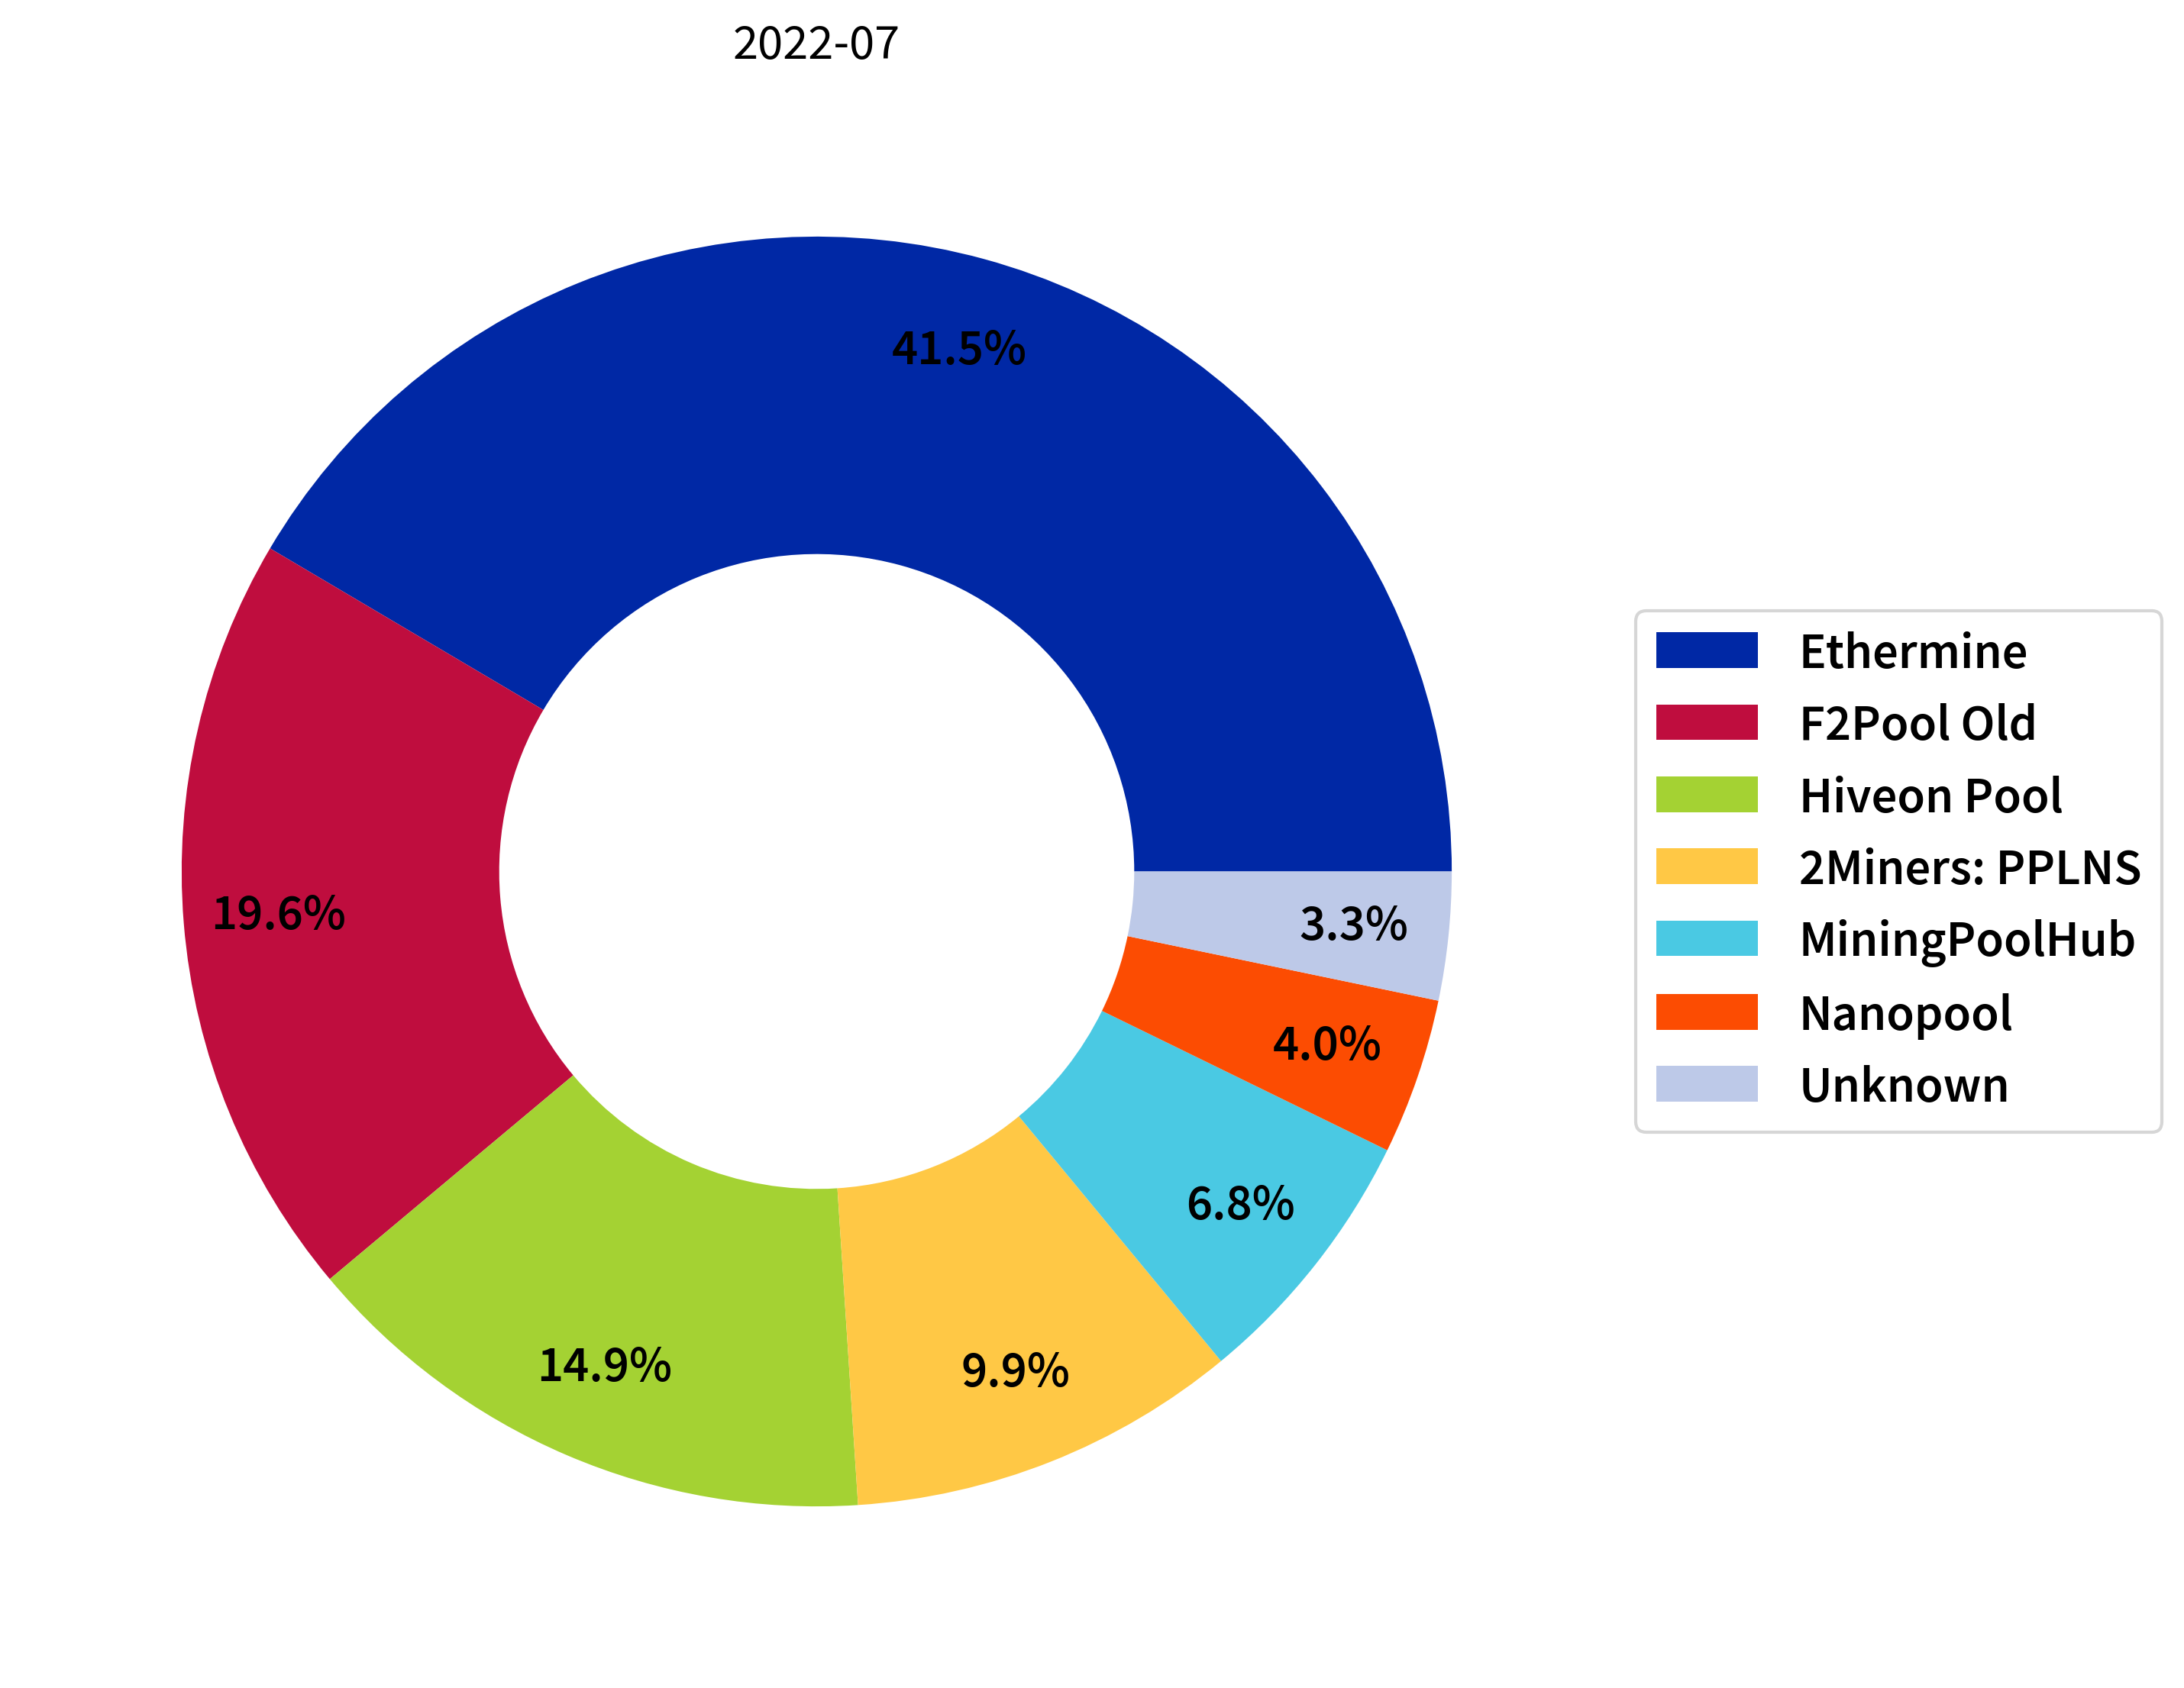

In [14]:
#画动图，展示每个月各个实体的质押比例
from matplotlib.animation import FuncAnimation, PillowWriter
fig, ax = plt.subplots(figsize=(16,9),facecolor='white')
def update(month):
    ax.clear()
    ax.set_facecolor('white')
    ax.pie(mining_pool_reward1[mining_pool_reward1['month']==month]['reward'],autopct='%1.1f%%',wedgeprops=dict(width=0.5),pctdistance=0.85)
    ax.legend(mining_pool_reward1[mining_pool_reward1['month']==month]['Name Tag'],loc='center left',bbox_to_anchor=(1,0,0.5,1))
    ax.set_title(f'{month}',fontsize=16)
    return ax
# ani = FuncAnimation(fig, update, frames=mining_pool_reward1['month'].unique(), interval=50,repeat=False)#interval=100（即100毫秒或0.1秒）
#改为每 3 个月更新一次
ani = FuncAnimation(fig, update, frames=mining_pool_reward1['month'].unique()[::3], interval=50,repeat=False)#interval=100（即100毫秒或0.1秒）
ani.save('/home/user/yan/github/ETH2.0-reward/code/pow_pos/plots/eth2_staking_ratio1.gif', writer=PillowWriter(fps=1), dpi=300,savefig_kwargs={'facecolor':'white'})